# 개와 고양이 사진 분류
---
로컬 pc에 저장되어 있는 이미지 데이터를 로딩해서 학습시키기기

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

## 데이터 준비

In [2]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip

--2023-01-05 03:29:03--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.122.128, 172.253.63.128, 142.251.111.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.122.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs_filtered.zip’

cats_and_dogs_filte 100%[===================>]  65.43M   219MB/s    in 0.3s    

2023-01-05 03:29:03 (219 MB/s) - ‘cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [3]:
!unzip cats_and_dogs_filtered.zip

Archive:  cats_and_dogs_filtered.zip
   creating: cats_and_dogs_filtered/
  inflating: cats_and_dogs_filtered/vectorize.py  
   creating: cats_and_dogs_filtered/validation/
   creating: cats_and_dogs_filtered/train/
   creating: cats_and_dogs_filtered/validation/dogs/
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2127.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2126.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2125.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2124.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2123.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2122.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2121.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2120.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2119.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2118.jpg  
  inflating: cats_and_dogs_filtered/validation/dogs/dog.2117.

In [4]:
import os

data_root = '/content/cats_and_dogs_filtered'
data_root

'/content/cats_and_dogs_filtered'

In [5]:
train_dir = os.path.join(data_root, 'train')
val_dir = os.path.join(data_root, 'validation')
train_dir

'/content/cats_and_dogs_filtered/train'

In [6]:
# 파일명 리스트 획득

train_cats_fname = os.listdir(os.path.join(train_dir, 'cats'))
train_dogs_fname = os.listdir(os.path.join(train_dir, 'dogs'))

print('cats:', len(train_cats_fname))
print('dogs:', len(train_dogs_fname))

cats: 1000
dogs: 1000


In [7]:
class_name = ['cat','dog']

In [8]:
import PIL

X_train = []
y_train = []

for i in range(len(train_cats_fname)):
  f = os.path.join(train_dir, 'cats', train_cats_fname[i])
  image = PIL.Image.open(f)
  image = image.resize((224,224))
  arr = np.array(image)
  X_train.append(arr)
  y_train.append(0)

In [9]:
for i in range(len(train_dogs_fname)):
  f = os.path.join(train_dir, 'dogs', train_dogs_fname[i])
  image = PIL.Image.open(f)
  image = image.resize((224,224))
  arr = np.array(image)
  X_train.append(arr)
  y_train.append(1)

### 검증용 데이터

In [11]:
# 파일명 리스트 획득

val_cats_fname = os.listdir(os.path.join(val_dir, 'cats'))
val_dogs_fname = os.listdir(os.path.join(val_dir, 'dogs'))

In [12]:
# 고양이
X_val = []
y_val = []

for i in range(len(val_cats_fname)):
  f = os.path.join(val_dir, 'cats', val_cats_fname[i])
  image = PIL.Image.open(f)
  image = image.resize((224,224))
  arr = np.array(image)
  X_val.append(arr)
  y_val.append(0)

In [13]:
# 강아지

for i in range(len(val_dogs_fname)):
  f = os.path.join(val_dir, 'dogs', val_dogs_fname[i])
  image = PIL.Image.open(f)
  image = image.resize((224,224))
  arr = np.array(image)
  X_val.append(arr)
  y_val.append(1)

In [14]:
X_train = np.array(X_train)
y_train = np.array(y_train)

X_val = np.array(X_val)
y_val = np.array(y_val)

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(2000, 224, 224, 3) (2000,)
(1000, 224, 224, 3) (1000,)


In [15]:
## 테스트 데이터 나누기
from sklearn.model_selection import train_test_split

X_val, X_test, y_val, y_test = train_test_split(X_val, y_val,
                                                test_size=0.2,
                                                random_state=2022)

X_val.shape, X_test.shape

((800, 224, 224, 3), (200, 224, 224, 3))

## 정규화

In [16]:
X_train = X_train.astype('float32')/255.
X_val = X_val.astype('float32')/255.
X_test = X_test.astype('float32')/255.

## 모델

In [29]:
model = keras.Sequential([
    layers.Conv2D(16, 3, input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.ReLU(),
    # 배치 후에 relu
    layers.MaxPooling2D(2),

    layers.Conv2D(32, 3),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(2),

    layers.Conv2D(64, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(2),
    # 여기까지가 필터 학습

    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['acc']
)

In [30]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 222, 222, 16)      448       
                                                                 
 batch_normalization_3 (Batc  (None, 222, 222, 16)     64        
 hNormalization)                                                 
                                                                 
 re_lu_1 (ReLU)              (None, 222, 222, 16)      0         
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 111, 111, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 109, 109, 32)      4640      
                                                                 
 batch_normalization_4 (Batc  (None, 109, 109, 32)    

### Callback

In [18]:
from tensorflow.keras import callbacks

call_path = 'callback.ckpt'

callpoint = callbacks.ModelCheckpoint(
    call_path,
    monitor = 'val_loss',
    save_weights_only = True,
    save_best_only = True,
    verbose = 1
)

In [19]:
# early stopping

es_callback = callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5
)

In [ ]:
EPOCHS = 30
BATCH_SIZE = 32

log = model.fit(X_train, y_train,
                epochs = EPOCHS,
                batch_size = BATCH_SIZE,
                validation_data = (X_val,y_val),
                callbacks = [callpoint, es_callback],
                verbose = 1)

## 평가

In [23]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(16,8))
    plt.subplot(1,2,1)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(hist['epoch'], hist['loss'],label='Train Loss')
    plt.plot(hist['epoch'], hist['val_loss'],label = 'Val Loss')
    plt.legend()

    plt.subplot(1,2,2)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.plot(hist['epoch'], hist['acc'],label='Train Accuracy')
    plt.plot(hist['epoch'], hist['val_acc'],label = 'Val Accuracy')

    plt.legend()
    plt.show()

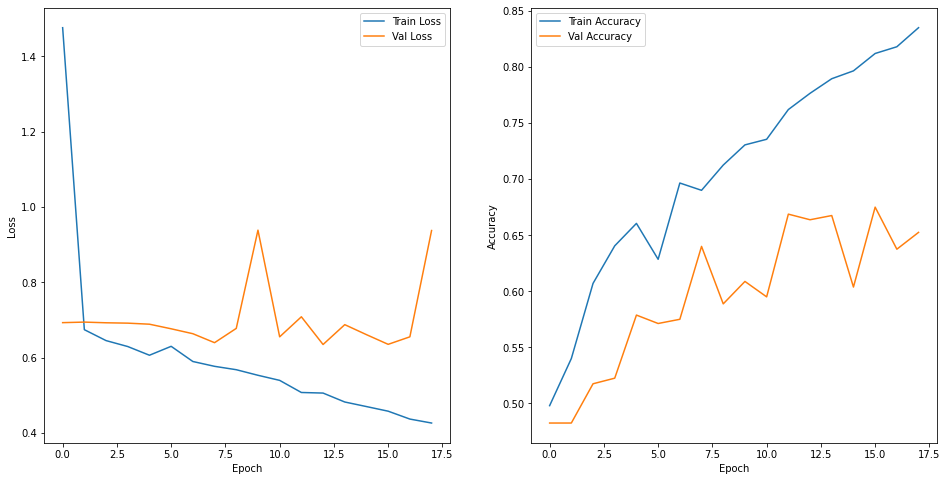

In [32]:
plot_history(log)

In [33]:
model.load_weights(call_path)

In [34]:
model.evaluate(X_test, y_test)

7/7 [==============================] - 0s 34ms/step - loss: 0.5377 - acc: 0.7150


[0.537727952003479, 0.7149999737739563]

In [37]:
y_pred = model.predict(X_test)
y_pred[:5]

7/7 [==============================] - 0s 21ms/step


array([[0.4113392 ],
       [0.58870584],
       [0.9776373 ],
       [0.89417136],
       [0.4113392 ]], dtype=float32)

In [40]:
y_pred = (y_pred > 0.5).astype(int).reshape(-1)
y_pred[:5]

array([0, 1, 1, 1, 0])

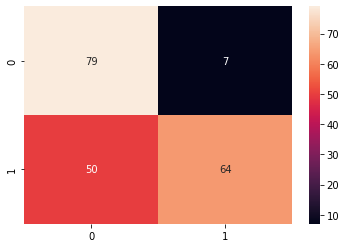

In [41]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

confusion = confusion_matrix(y_test, y_pred)
sns.heatmap(confusion, annot=True, fmt='1g')

## 튜닝

In [55]:
model = keras.Sequential([
    layers.Conv2D(16, 3, input_shape=(224, 224, 3)),
    layers.BatchNormalization(),
    layers.ReLU(),
    # 배치 후에 relu
    layers.MaxPooling2D(2),

    layers.Conv2D(32, 3),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(2),

    layers.Conv2D(64, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(2),
    # 여기까지가 필터 학습

    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(32, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    optimizer = 'rmsprop',
    loss = 'binary_crossentropy',
    metrics = ['acc']
)

In [57]:
EPOCHS = 30
BATCH_SIZE = 32

log = model.fit(X_train, y_train,
                epochs = EPOCHS,
                batch_size = BATCH_SIZE,
                validation_data = (X_val,y_val),
                callbacks = [callpoint, es_callback],
                verbose = 1)

Epoch 1/30
62/63 [============================>.] - ETA: 0s - loss: 1.3025 - acc: 0.5791
Epoch 1: val_loss did not improve from 0.60137
63/63 [==============================] - 5s 59ms/step - loss: 1.2975 - acc: 0.5785 - val_loss: 0.6897 - val_acc: 0.5663
Epoch 2/30
63/63 [==============================] - ETA: 0s - loss: 0.6301 - acc: 0.6620
Epoch 2: val_loss did not improve from 0.60137
63/63 [==============================] - 3s 48ms/step - loss: 0.6301 - acc: 0.6620 - val_loss: 0.6856 - val_acc: 0.5437
Epoch 3/30
63/63 [==============================] - ETA: 0s - loss: 0.5385 - acc: 0.7275
Epoch 3: val_loss did not improve from 0.60137
63/63 [==============================] - 3s 53ms/step - loss: 0.5385 - acc: 0.7275 - val_loss: 0.7396 - val_acc: 0.5175
Epoch 4/30
63/63 [==============================] - ETA: 0s - loss: 0.5092 - acc: 0.7560
Epoch 4: val_loss did not improve from 0.60137
63/63 [==============================] - 4s 56ms/step - loss: 0.5092 - acc: 0.7560 - val_loss: 0

In [59]:
model.load_weights(call_path)

ValueError: ignored

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
plot_history(log)